In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from tqdm import tqdm
import keras
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Reshape, core, Dropout, BatchNormalization, concatenate, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score
import tensorflow as tf
from loss_functions import jaccard_loss, iou_metric
from keras.regularizers import l2 as l2_reg
import predict_all_img
#from predict_all_img import split_image
%matplotlib inline

Using TensorFlow backend.


In [2]:
def split_image(img_dir, img_name, model, size = (192,240), shear = 0.25, img_type='tsunami'):
    if img_type == 'tsunami':
        img_1_path = img_dir+'t0/'+img_name+'.jpg'
        img_2_path = img_dir+'t1/'+img_name+'.jpg'
        img_gt_path = img_dir+'ground_truth/'+img_name+'.bmp'
        
    elif img_type == 'aicd':
        img_1_path = img_dir+'Images_NoShadow/'+img_name+'.png'
        img_2_path = img_dir+'Images_NoShadow/'+img_name+'.png'
        img_gt_path = img_dir+'GroundTruth/'+img_name+'.png'
        
    img_1 = cv2.imread(img_1_path)
    img_2 = cv2.imread(img_2_path)
    img_gt = cv2.imread(img_gt_path,0)

    if img_type=='tsunami':
        img_gt = cv2.bitwise_not(img_gt)
        
    img = np.empty((img_1.shape[0], img_1.shape[1], 6))
    img[:, :, :3] = img_1/255
    img[:, :, 3:] = img_2/255
    #img_gt = img_gt/255
                   
    h,w,_ = img.shape
    print(img.shape)
    # Create reflective padding
    shear_int = (int(size[0]*shear),int(size[1]*shear))
    pad_h_1 = (size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))//2
    pad_h_2 = (size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))//2+(size[0]-shear_int[0]-(h-size[0])%(size[0]-shear_int[0]))%2
    pad_w_1 = (size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))//2
    pad_w_2 = (size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))//2+(size[1]-shear_int[1]-(w-size[1])%(size[1]-shear_int[1]))%2
    print(pad_h_1,pad_h_2,pad_w_1,pad_w_2)
    img = np.pad(img,((pad_h_1,pad_h_2),(pad_w_1,pad_w_2),(0,0)), 'reflect')
    
    # Split image into patches
    h,w,_ = img.shape
    img_arr = []
    n_rows = (h-size[0])//(size[0]-shear_int[0])+1
    n_cols = (w-size[1])//(size[1]-shear_int[1])+1
    for i in range(n_rows):
        for j in range(n_cols):
            coord_h = i*(size[0]-shear_int[0])
            coord_w = j*(size[1]-shear_int[1])
            img_crop = img[coord_h:coord_h+size[0], coord_w:coord_w+size[1],:]
            img_arr.append(img_crop)
 
    # Create predictions for patches
    mask_arr = []
    for img_crop in img_arr:
        img_to_pred = np.array([img_crop])
        mask_pred = model.predict(img_to_pred)[0]
        mask_arr.append(mask_pred)
    
    # Merge masks in one
    index = 0
    channels = 1
    final_seg = np.zeros((h,w))
    print(final_seg.shape)
    for i in range (n_rows):
        for j in range (n_cols):
            #print(i,j)
            coord_h = i*(size[0]-shear_int[0])
            coord_w = j*(size[1]-shear_int[1])
            
            shift_h = shear_int[0]//2
            shift_w = shear_int[1]//2
            
            mask_to_append = mask_arr[index]
            mask_to_append[0:shift_h,:]=0
            mask_to_append[size[0]-shift_h:,:]=0
            mask_to_append[:,0:shift_w]=0
            mask_to_append[:,size[1]-shift_w:]=0
                
            final_seg[coord_h:coord_h+size[0], coord_w:coord_w+size[1]]+=mask_to_append
            index+=1
    #print(final_seg.shape)
    print(final_seg.shape)
    final_seg = final_seg[pad_h_1:h-pad_h_2, pad_w_1:w-pad_w_2]
    print(final_seg.shape)
    return final_seg, img_gt

In [3]:
DATASET_DIR='data/train_test_val_tsunami_reduced/'
smooth = 1e-12

In [4]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, 1, 2])
    sum_ = K.sum(y_true + y_pred, axis=[0, 1, 2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, 1, 2])
    sum_ = K.sum(y_true + y_pred, axis=[0, 1, 2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jac_loss(y_true, y_pred):
    return 1-jaccard_coef_int(y_true, y_pred)

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=[0, 1, 2])
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=[0, 1, 2])
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=[0, 1, 2])
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=[0, 1, 2])
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_))

In [5]:
class BatchGeneratorStatic(object):
    
    def __init__(self, batch_size = 32, dim_x = 240, dim_y = 192, dim_z = 6, shuffle = True):
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = dim_z
        self.batch_size = batch_size
        self.shuffle = shuffle

    def generate(self, dir_name, file_names):
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(file_names)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                # Find list of IDs
                list_files_temp = [file_names[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
                # Generate data
                X_out, y_out = self.data_generation(dir_name, list_files_temp)

                yield X_out, y_out

    def __get_exploration_order(self, X):
        
        # Find exploration order
        indexes = np.arange(len(X))
        if self.shuffle == True:
            np.random.shuffle(indexes)

        return indexes

    def data_generation(self, dir_name, list_files_temp):
        # X : (n_samples, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_y, self.dim_x, self.dim_z))
        y = np.empty((self.batch_size, self.dim_y, self.dim_x))

        # Generate data
        for i in range(len(list_files_temp)):
            # Store volume
            img_1 = cv2.imread(dir_name+'1/'+list_files_temp[i])
            img_2 = cv2.imread(dir_name+'2/'+list_files_temp[i])
            img_gt = cv2.imread(dir_name+'gt/'+list_files_temp[i],0)
            
            #print(img.shape)
            X[i, :, :, :3] = img_1/255
            X[i, :, :, 3:] = img_2/255
            
            y[i, :, :]=img_gt/255

            
            #y = y/255
            #y=y.flatten()
        return X, y
    def debug(self, X, y):
        indexes = self.__get_exploration_order(X)
        imax = int(len(indexes)/self.batch_size)
        for i in range(1):
            # Find list of IDs
            list_files_temp = [file_names[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]
            # Generate data
            X_out, y_out = self.data_generation(dir_name, list_files_temp)
            return  X_out, y_out

In [6]:
# dir_name = DATASET_DIR+'test/'
# file_names = os.listdir(dir_name+'1/')

# X,y = BatchGeneratorStatic().debug(dir_name, file_names)

In [7]:
# LOADING DATASETS
train_dir = DATASET_DIR+'train/'
train_data = os.listdir(DATASET_DIR+'train/1')
val_dir = DATASET_DIR+'val/'
val_data = os.listdir(DATASET_DIR+'val/1')

In [8]:
inputs = Input((192,240,6))
bn0 = BatchNormalization()(inputs)

conv1 = Conv2D(64, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(bn0)
bn1 = BatchNormalization()(conv1)
ac1 = Activation('relu')(bn1)
mp1 = MaxPooling2D(pool_size=(2, 2), strides=2)(ac1)

conv2 = Conv2D(128, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(mp1)
bn2 = BatchNormalization()(conv2)
ac2 = Activation('relu')(bn2)
mp2 = MaxPooling2D(pool_size=(2, 2), strides=2)(ac2)

conv3 = Conv2D(256, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(mp2)
bn3 = BatchNormalization()(conv3)
ac3 = Activation('relu')(bn3)
mp3 = MaxPooling2D(pool_size=(2, 2), strides=2)(ac3)

conv4 = Conv2D(512, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(mp3)
bn4 = BatchNormalization()(conv4)
ac4 = Activation('relu')(bn4)
mp4 = MaxPooling2D(pool_size=(2, 2), strides=2)(ac4)

up5 = UpSampling2D((2, 2))(mp4)
conv5 = Conv2D(512, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(up5)
bn5 = BatchNormalization()(conv5)
ac5 = Activation('relu')(bn5)

up6 = UpSampling2D((2, 2))(ac5)
conv6 = Conv2D(256, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(up6)
bn6 = BatchNormalization()(conv6)
ac6 = Activation('relu')(bn6)

up7 = UpSampling2D((2, 2))(ac6)
conv7 = Conv2D(128, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(up7)
bn7 = BatchNormalization()(conv7)
ac7 = Activation('relu')(bn7)

up8 = UpSampling2D((2, 2))(ac7)
conv8 = Conv2D(64, (7, 7), padding='same', kernel_regularizer=l2_reg(0.001))(up8)
bn8 = BatchNormalization()(conv8)
ac8 = Activation('relu')(bn8)

conv9 = Conv2D(1, (7, 7), activation='sigmoid', padding='same', kernel_regularizer=l2_reg(0.001))(ac8)

rh1 = Reshape((192, 240))(conv9)
#rh1 = Flatten()(conv9)

model = Model(inputs=inputs, outputs=rh1)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 240, 6)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 240, 6)       24        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 240, 64)      18880     
_________________________________________________________________
batch_normalization_2 (Batch (None, 192, 240, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 192, 240, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 120, 128)      401536    
__________

In [18]:
inputs = Input((192,240,6))
bn1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), padding='same')(bn1)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
conv1 = Conv2D(32, (3, 3), padding='same')(act1)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
pool1 = MaxPooling2D(pool_size=(2, 2))(act1)

conv2 = Conv2D(64, (3, 3), padding='same')(pool1)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
conv2 = Conv2D(64, (3, 3), padding='same')(act2)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)
pool2 = MaxPooling2D(pool_size=(2, 2))(act2)

conv3 = Conv2D(128, (3, 3), padding='same')(pool2)
bn3 = BatchNormalization()(conv3)
act3 = Activation('relu')(bn3)
conv3 = Conv2D(128, (3, 3), padding='same')(act3)
bn3 = BatchNormalization()(conv3)
act3 = Activation('relu')(bn3)
pool3 = MaxPooling2D(pool_size=(2, 2))(act3)

conv4 = Conv2D(256, (3, 3), padding='same')(pool3)
bn4 = BatchNormalization()(conv4)
act4 = Activation('relu')(bn4)
conv4 = Conv2D(256, (3, 3), padding='same')(act4)
bn4 = BatchNormalization()(conv4)
act4 = Activation('relu')(bn4)
pool4 = MaxPooling2D(pool_size=(2, 2))(act4)

conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)
conv5 = Conv2D(512, (3, 3), padding='same')(act5)
bn5 = BatchNormalization()(conv5)
act5 = Activation('relu')(bn5)

up6 = concatenate([UpSampling2D(size=(2, 2))(act5), act4], axis=3)
conv6 = Conv2D(256, (3, 3), padding='same')(up6)
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)
conv6 = Conv2D(256, (3, 3), padding='same')(act6)
bn6 = BatchNormalization()(conv6)
act6 = Activation('relu')(bn6)

up7 = concatenate([UpSampling2D(size=(2, 2))(act6), act3], axis =3 )
conv7 = Conv2D(128, (3, 3), padding='same')(up7)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)
conv7 = Conv2D(128, (3, 3), padding='same')(act7)
bn7 = BatchNormalization()(conv7)
act7 = Activation('relu')(bn7)

up8 = concatenate([UpSampling2D(size=(2, 2))(act7), act2], axis=3)
conv8 = Conv2D(64, (3, 3), padding='same')(up8)
bn8 = BatchNormalization()(conv8)
act8 = Activation('relu')(bn8)
conv8 = Conv2D(64, (3, 3), padding='same')(act8)
bn8 = BatchNormalization()(conv8)
act8 = Activation('relu')(bn8)

up9 = concatenate([UpSampling2D(size=(2, 2))(act8), act1], axis=3)
conv9 = Conv2D(32, (3, 3), padding='same')(up9)
bn9 = BatchNormalization()(conv9)
act9 = Activation('relu')(bn9)
conv9 = Conv2D(32, (3, 3), padding='same')(act9)
bn9 = BatchNormalization()(conv9)
act9 = Activation('relu')(bn9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(act9)

rh1 = Reshape((192, 240))(conv10)

model = Model(inputs=inputs, outputs=rh1, name = 'Unet')
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 192, 240, 6)   0                                            
____________________________________________________________________________________________________
batch_normalization_28 (BatchNor (None, 192, 240, 6)   24          input_4[0][0]                    
____________________________________________________________________________________________________
conv2d_28 (Conv2D)               (None, 192, 240, 32)  1760        batch_normalization_28[0][0]     
____________________________________________________________________________________________________
batch_normalization_29 (BatchNor (None, 192, 240, 32)  128         conv2d_28[0][0]                  
___________________________________________________________________________________________

In [9]:
optimizer = keras.optimizers.SGD(lr=0.005)
model.compile(loss=jaccard_loss, optimizer=optimizer, metrics=[jaccard_coef_int, iou_metric, precision, recall, f1])
batch_size = 5
training_generator = BatchGeneratorStatic(batch_size = batch_size).generate(train_dir, train_data)
validation_generator = BatchGeneratorStatic(batch_size = batch_size).generate(val_dir, val_data)

In [18]:
model.fit_generator(generator = training_generator,
                        steps_per_epoch = 400,
                        validation_data = validation_generator,
                        validation_steps = int(len(val_data)//batch_size), verbose = True,epochs= 1)

Epoch 1/1
400/400 [==============================] - 1209s - loss: 1.9199 - jaccard_coef_int: 0.6906 - iou_metric: 0.6906 - precision: 0.7693 - recall: 0.8764 - f1: 0.8132 - val_loss: 1.9222 - val_jaccard_coef_int: 0.6825 - val_iou_metric: 0.6825 - val_precision: 0.7612 - val_recall: 0.8680 - val_f1: 0.8084


In [19]:
model.save_weights('weights/tsunami-5-4weights_1ep_0005lr_tr06906iou_val06825iou.4f')

In [10]:
model.load_weights('weights/tsunami-5-4weights_1ep_0005lr_tr06906iou_val06825iou.4f')

In [11]:
# LOADING DATASETS
train_dir = DATASET_DIR+'train/'
train_data = os.listdir(DATASET_DIR+'train/1')
val_dir = DATASET_DIR+'val/'
val_data = os.listdir(DATASET_DIR+'val/1')
test_dir = DATASET_DIR+'test/'
test_data = os.listdir(DATASET_DIR+'test/1')

In [21]:
mode='val'
all_img=False

if mode=='val':
    data_dir=val_dir
    data=val_data
elif mode=='train':
    data_dir=train_dir
    data=train_data
elif mode=='test':
    data_dir=test_dir
    data=test_data
    
len_data=len(data)
if not all_img:
    len_data = 100

X = np.empty((len_data, 192, 240, 6))
y = np.empty((len_data, 192, 240))

# Generate data
for i in range(len_data):
    # Store volume
    img_1 = cv2.imread(data_dir+'1/'+data[i])
    img_2 = cv2.imread(data_dir+'2/'+data[i])
    img_gt = cv2.imread(data_dir+'gt/'+data[i],0)

    #print(img.shape)
    X[i, :, :, :3] = img_1/255
    X[i, :, :, 3:] = img_2/255

    y[i, :, :]=img_gt/255


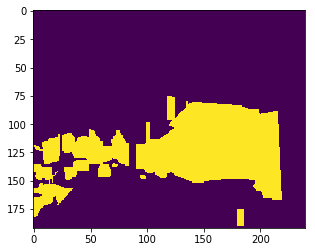

In [26]:
plt.imshow(y[0,:,:])

In [27]:
y_pred = model.predict(X[0:1,:,:])

In [44]:
batch_size = 5

y_pred = np.empty((len(data), 192, 240))

for i in tqdm(range(0, len(data), batch_size)):
    y_pred[i:i+batch_size,:,:] = model.predict(X[i:i+batch_size,:,:])

100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


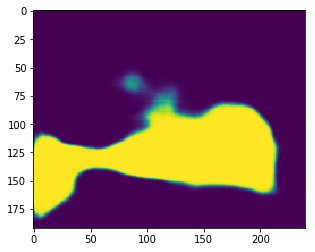

In [28]:
plt.imshow(y_pred[0,:,:])

(224, 1024, 6)
56 56 58 58
(336, 1140)
(336, 1140)
(224, 1024)


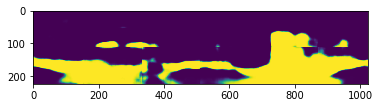

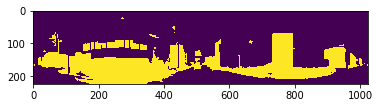

In [21]:
img, img_gt = split_image('data/TSUNAMI/', '00000075', model)
plt.imshow(img)
plt.show()
img_gt = img_gt/255
plt.imshow(img_gt)
plt.show()

In [22]:
img_=img.reshape(224, 1024, 1)
img_gt_=img_gt.reshape(224, 1024, 1)

In [49]:
print(np_jaccard_coef(y_pred , y))
print(np_precision(y_pred ,y))
print(np_recall(y_pred ,y))
print(np_f1(y_pred ,y))

0.753617163995
0.86400910268
0.858551990331
0.861271902378


0.86400910267979758

In [31]:
def np_jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = np.sum(y_true * y_pred)
    sum_ = np.sum(y_true + y_pred)

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return np.mean(jac)

def np_recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives)
    return recall

def np_precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives)
    return precision

def np_f1(y_true, y_pred):
    precision_ = np_precision(y_true, y_pred)
    recall_ = np_recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_))